In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
connect = sqlite3.connect('dinofunworld.db')
cursor = connect.cursor()

In [3]:
# Question 1: A distance matrix for 5 visitors as a dictionary of ids, each property has another dictionaries
# with the other visitors' ids and tthe count for heir differences with the outer id 
visitor_ids = [165316, 1835254, 296394, 404385, 448990]
visitor_ids_string = ", ".join(map(str, visitor_ids))

cursor.execute(f"SELECT visitorID, sequence FROM sequences where visitorID IN ({visitor_ids_string});")
sequences = cursor.fetchall()
sequences_data = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])

sequences_data['sequences_list'] = sequences_data['sequence'].apply(lambda x: x.split("-"))

visitors_dict = {}
for i in range(len(visitor_ids)):
    for j in range(i+1, len(visitor_ids)):
        dist = sum(int(a) != int(b) for a, b in zip(sequences_data['sequences_list'][i], sequences_data['sequences_list'][j]))
        id_i = sequences_data['visitor'][i]
        id_j = sequences_data['visitor'][j]
        distance_dict_i = visitors_dict.get(id_i, {})
        distance_dict_i[id_j] = dist
        visitors_dict[id_i] = distance_dict_i
        distance_dict_j = visitors_dict.get(id_j, {})
        distance_dict_j[id_i] = dist
        visitors_dict[id_j] = distance_dict_j

print(visitors_dict)

{165316: {296394: 318, 404385: 329, 448990: 318, 1835254: 336}, 296394: {165316: 318, 404385: 303, 448990: 0, 1835254: 282}, 404385: {165316: 329, 296394: 303, 448990: 303, 1835254: 298}, 448990: {165316: 318, 296394: 0, 404385: 303, 1835254: 282}, 1835254: {165316: 336, 296394: 282, 404385: 298, 448990: 282}}


In [4]:
# Preparing a data frame for questions 2 and 3
cursor.execute("SELECT AttractionID, Name FROM attraction where LOWER(Category) LIKE '%ride%';")
attraction_name_category_list = cursor.fetchall()
attractions = pd.DataFrame.from_records(attraction_name_category_list, columns=['AttractionID', 'Name'])

cursor.execute("SELECT visitorID, sequence FROM sequences;")
sequences = cursor.fetchall()
sequences_data = pd.DataFrame.from_records(sequences, columns=['visitor', 'sequence'])
sequences_data['sequence_list'] = sequences_data['sequence'].apply(lambda x: x.split("-"))

dict_for_graph = {}
sequence_attendence_col_name = "sequence_attendance"
for i in range(len(attraction_name_category_list)):
    sequences_data[sequence_attendence_col_name] = sequences_data['sequence_list'].apply(lambda x: [1 if int(y) == int(attraction_name_category_list[i][0]) else 0 for y in x])
    attendance = np.sum(sequences_data[sequence_attendence_col_name].values.tolist(), axis=0)
    attendance = attendance[np.nonzero(attendance)]
    min_attendance = np.min(attendance)
    avg_attendance = np.mean(attendance)
    max_attendance = np.max(attendance)
    temp_dict = {"min": min_attendance, "avg": avg_attendance, "max": max_attendance}
    dict_for_graph[attraction_name_category_list[i][1]] = temp_dict

frame = pd.DataFrame.from_dict(dict_for_graph, orient='index')
frame = frame.reset_index()
frame.columns = ['ride' if x=='index' else x for x in frame.columns]

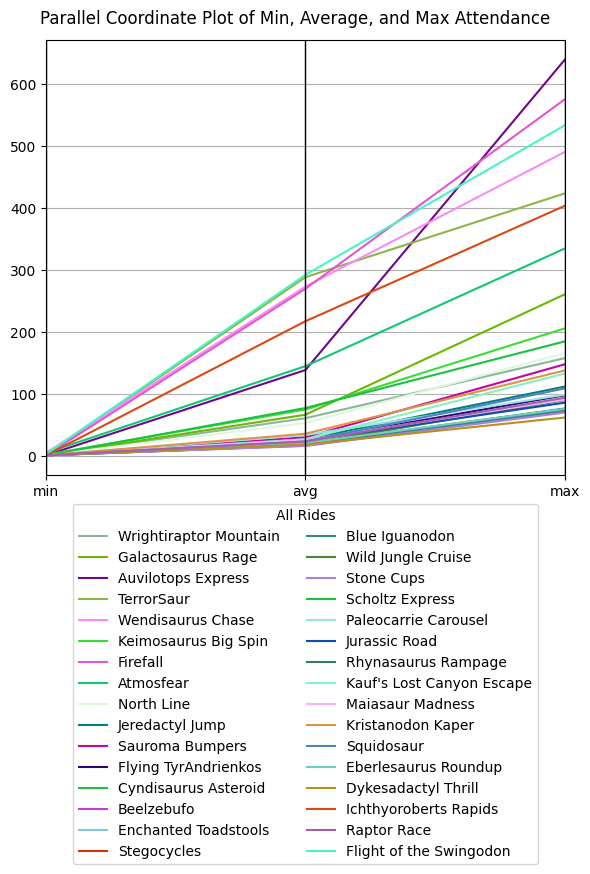

In [5]:
# Question 2: A Parallel Coordinate Plot with the minimum (non-zero) attendance at each ride,
# the average attendance over the whole day,and the maximum attendance
plt.figure(figsize=(6, 9))
ax = pd.plotting.parallel_coordinates(frame, 'ride')
ax.legend(title='All Rides', loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.suptitle('Parallel Coordinate Plot of Min, Average, and Max Attendance')
plt.tight_layout()
plt.show()

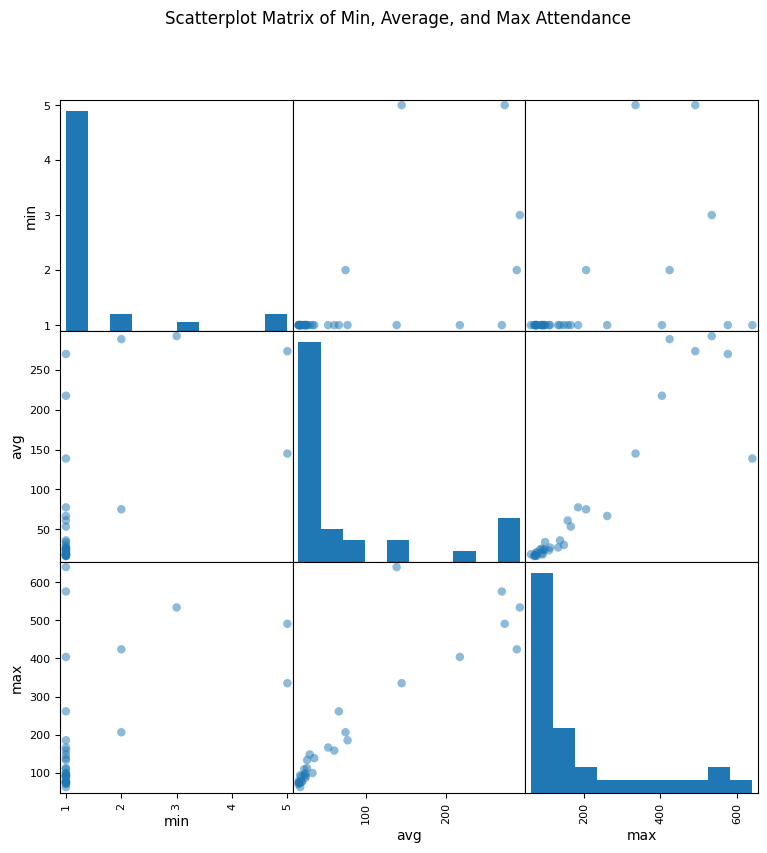

In [6]:
# Question 3: A Scatterplot Matrix with the minimum (non-zero) attendance at each ride,
# the average attendance over the whole day,and the maximum attendance
pd.plotting.scatter_matrix(frame, figsize=(9, 9), alpha=0.5, s=150)
plt.suptitle('Scatterplot Matrix of Min, Average, and Max Attendance')
plt.show()